<a href="https://colab.research.google.com/github/rafiqhasan/AI_DL_ML_Repo/blob/master/All%20TFX/Vertex%20AI/DL_E2E_%7C_Taxi_TFX_E2E_TFT_Real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **TensorFlow Extended (TFX)** 
Is an end-to-end platform for deploying production ML pipelines

WorkShop - https://github.com/GoogleCloudPlatform/mlops-on-gcp/blob/master/workshops/tfx-caip-tf23/lab-01-tfx-walkthrough/solutions/lab-01.ipynb

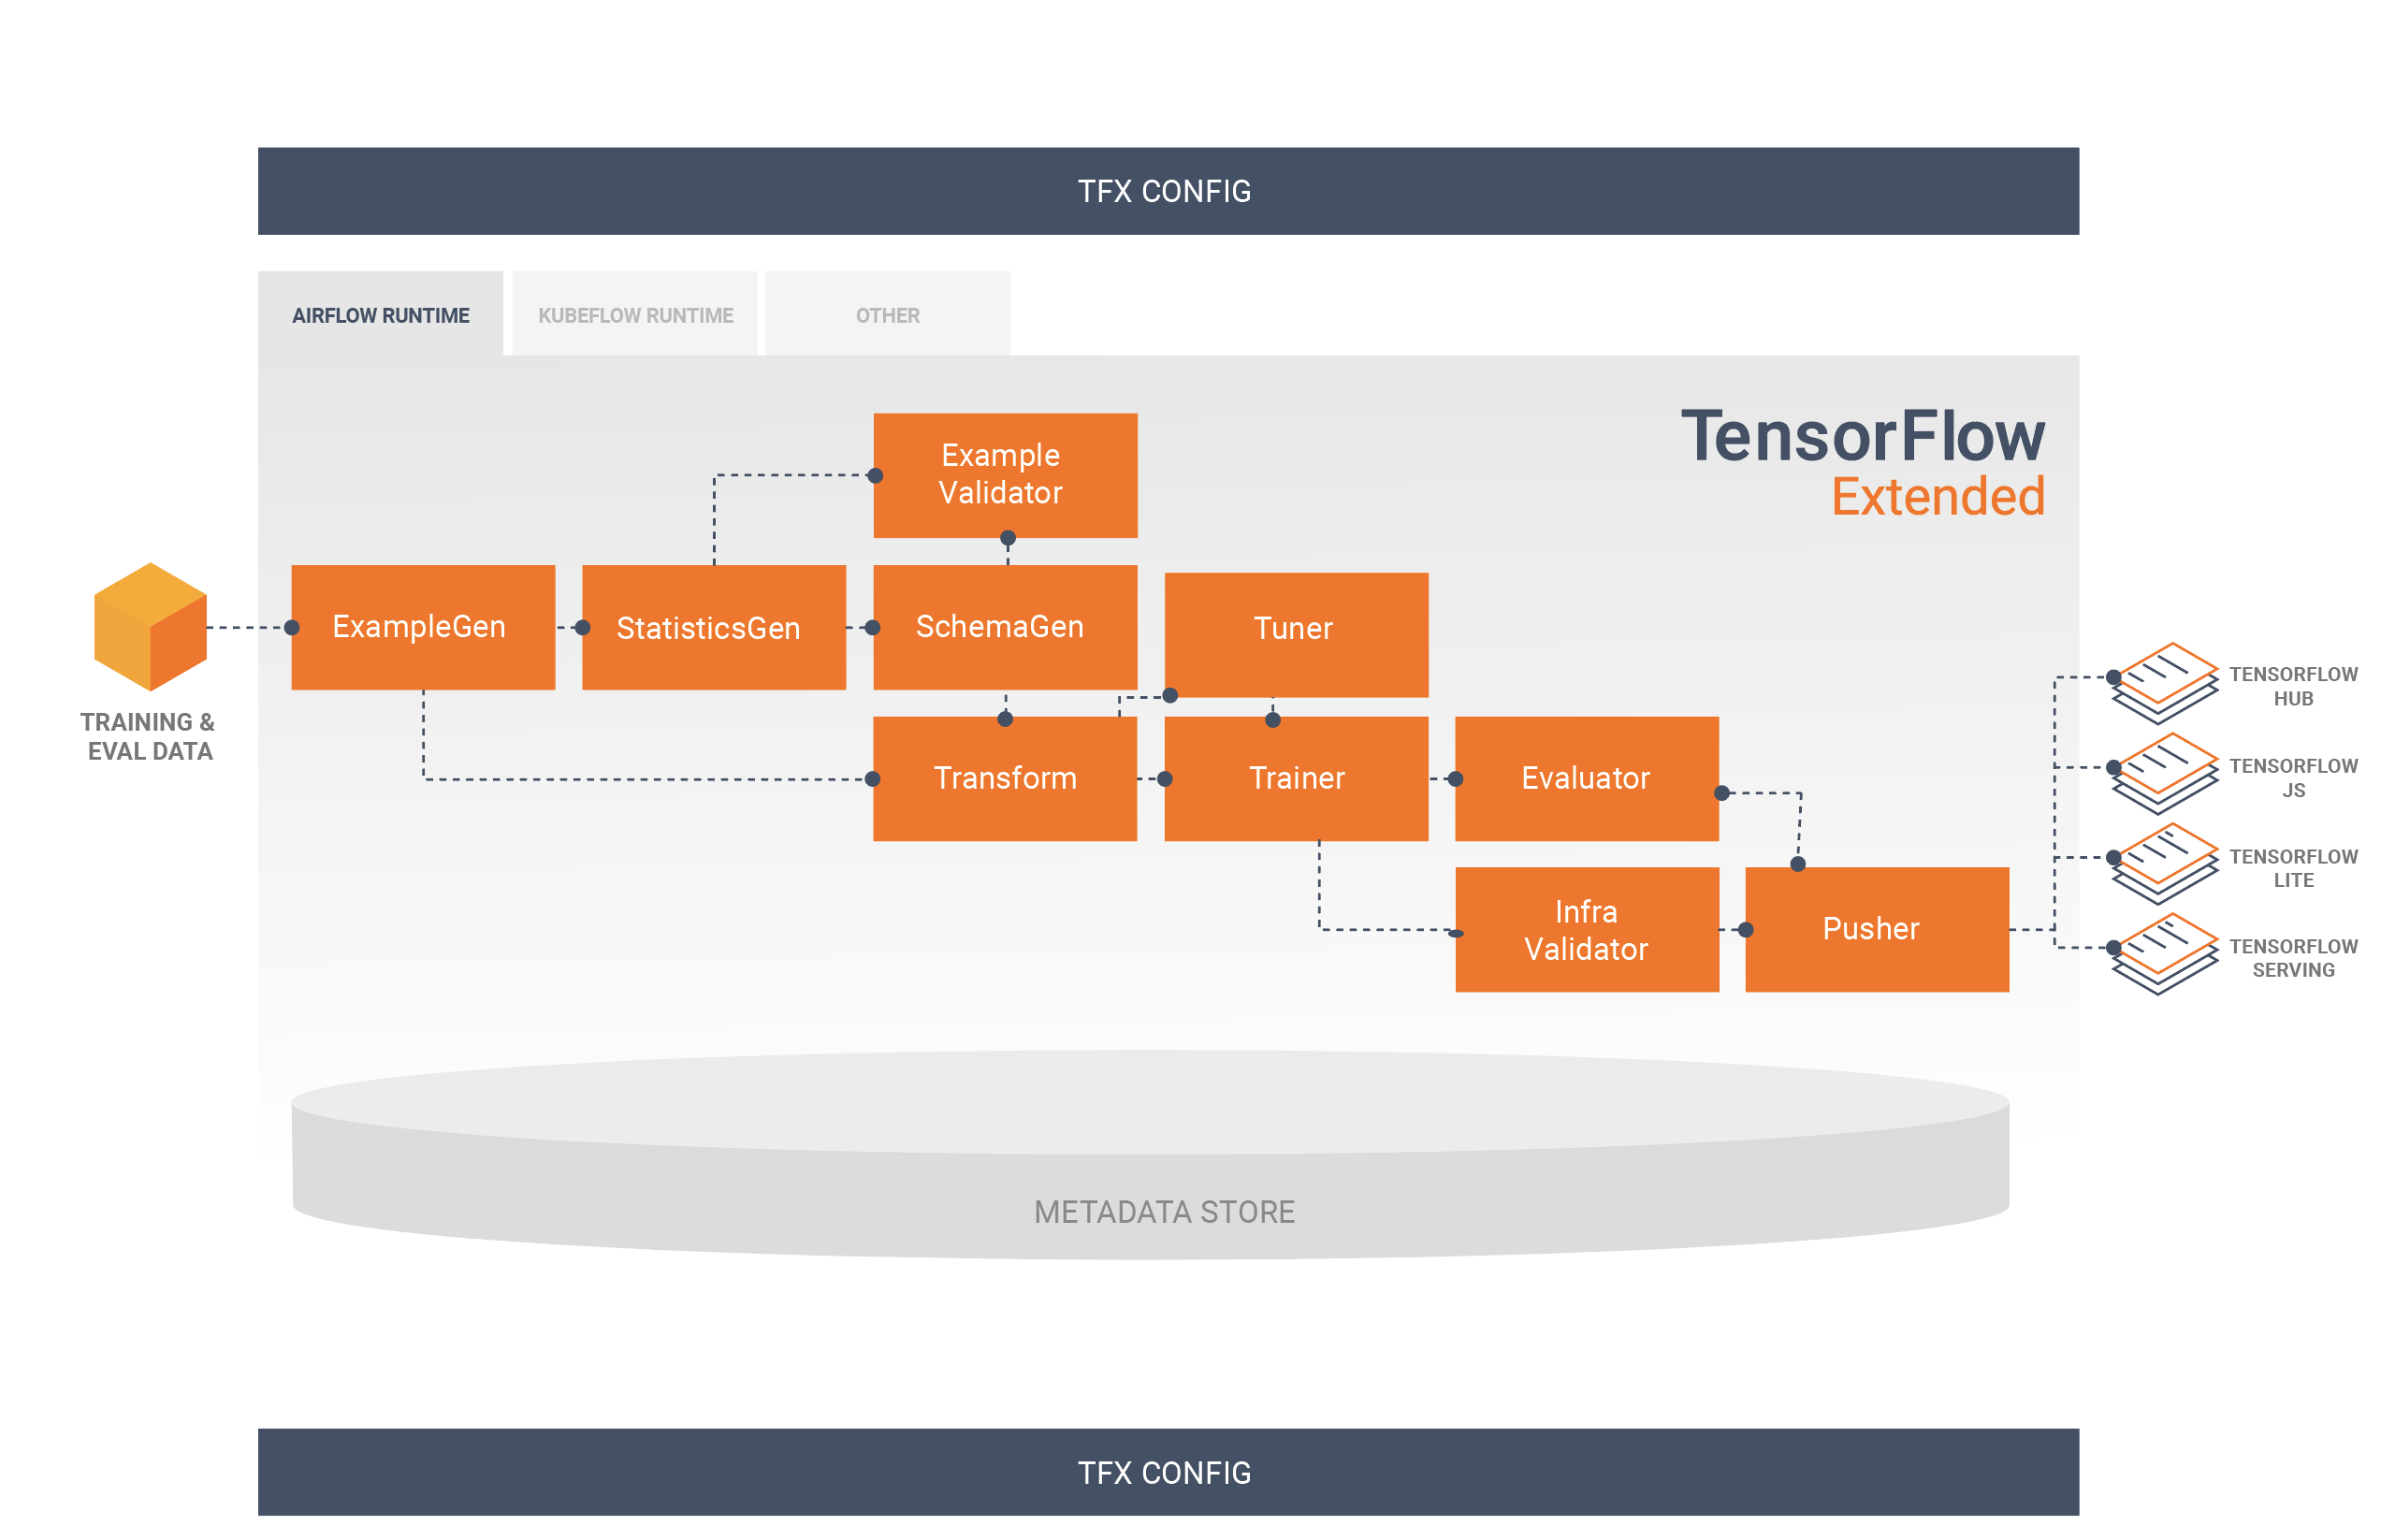

### **Corresponding TFX libraries per component**:

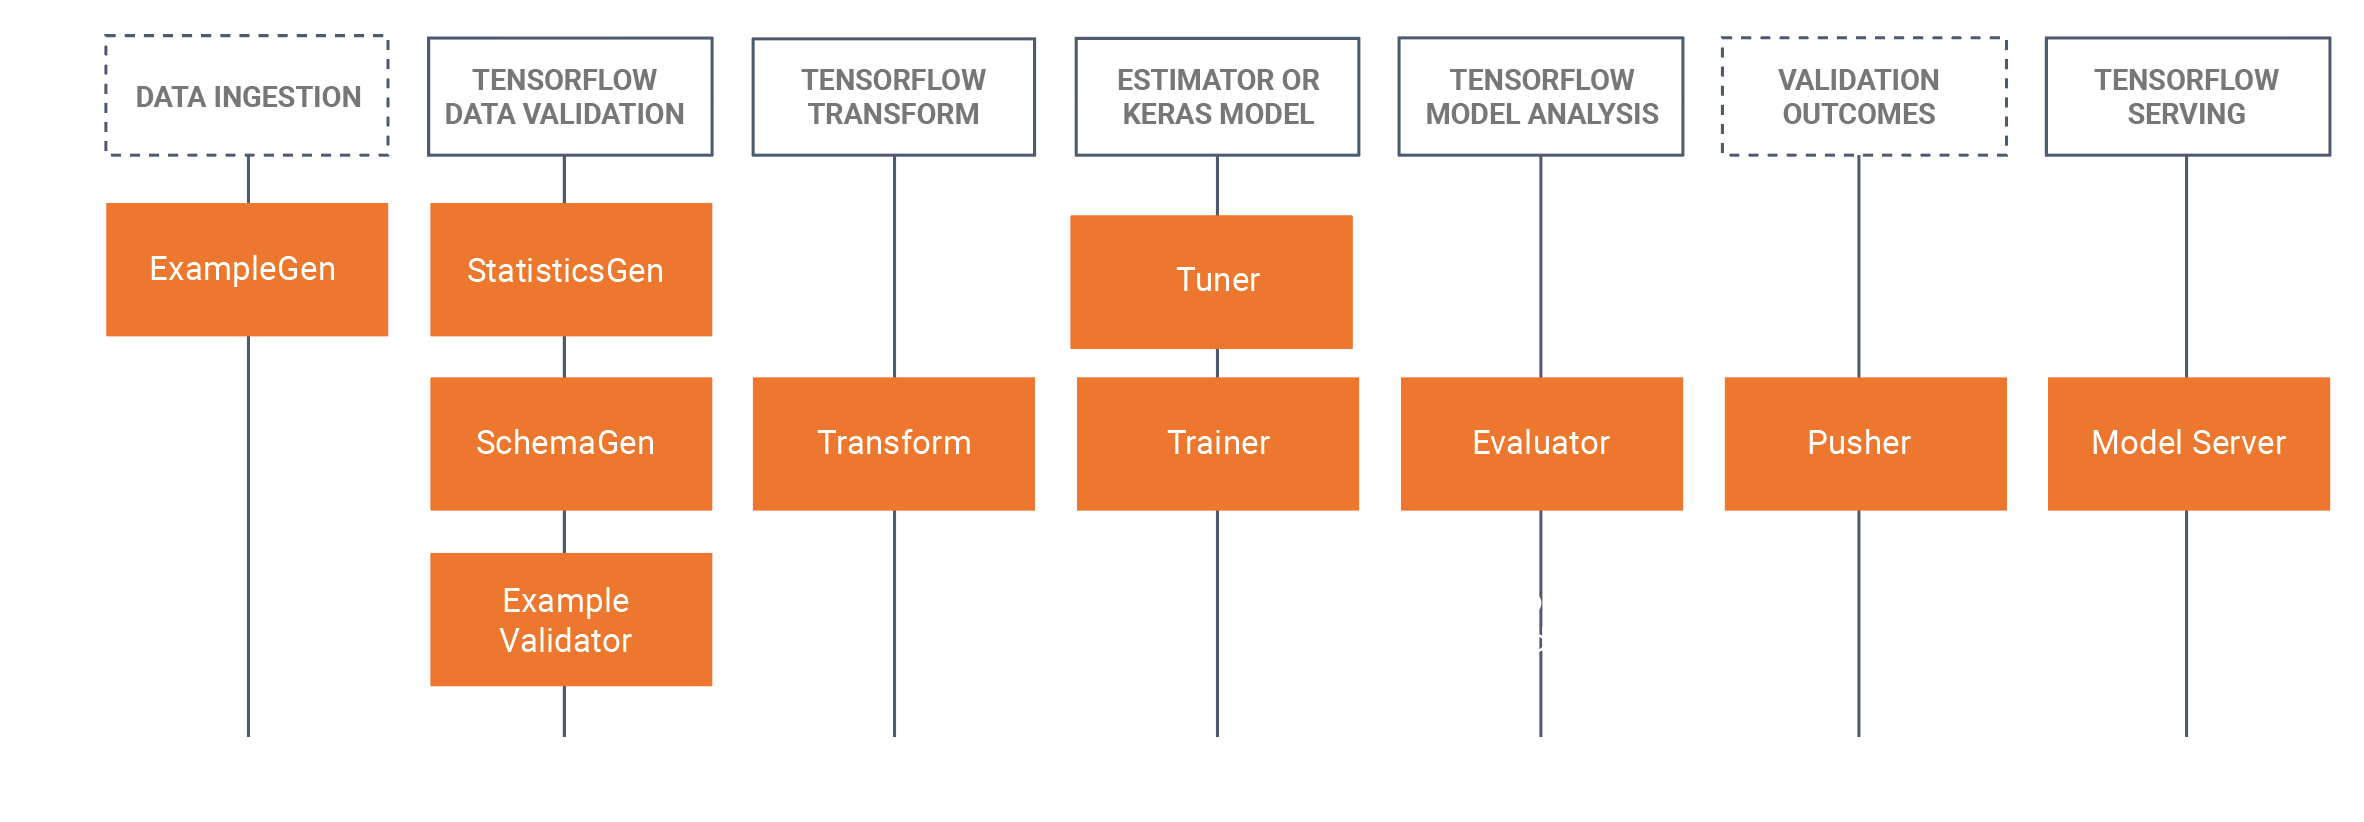

In [ ]:
!pip install tfx

In [ ]:
import os
import pprint
import numpy as np
import tempfile
import urllib

import absl
import pandas as pd
import tensorflow as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

import tfx
from tfx.components import CsvExampleGen
from typing import Dict, List, Text
from tfx.components import Evaluator
from tfx.components import ExampleValidator
from tfx.components import Pusher
# from tfx.components import ResolverNode
from tfx.components.common_nodes.importer_node import ImporterNode
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Trainer
from tfx.components import Transform, InfraValidator
from tfx.components import Tuner
from tfx.components.base import executor_spec
from tfx.components.trainer.executor import GenericExecutor
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2
from tfx.types import Channel
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import ModelBlessing
# from tfx.utils.dsl_utils import external_input

from tfx.proto import infra_validator_pb2
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import HyperParameters
from tfx.types.standard_artifacts import ModelBlessing
from tfx.types.standard_artifacts import InfraBlessing

%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

Let's check the library versions.

In [ ]:
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

In [ ]:
!rm -rf data.*
!rm -rf *trainer.py
!sudo rm -r /content/tfx

In [ ]:
! cd /content/
! mkdir /content/tfx/
! mkdir /content/tfx/pipelines
! mkdir /content/tfx/metadata
! mkdir /content/tfx/logs
! mkdir /content/tfx/data
! mkdir /content/tfx/serving_model

### Download example data
We download the example dataset for use in our TFX pipeline.

The dataset we're using is the [Taxi Trips dataset](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew) released by the City of Chicago. The columns in this dataset are:

<table>
<tr><td>pickup_community_area</td><td>fare</td><td>trip_start_month</td></tr>
<tr><td>trip_start_hour</td><td>trip_start_day</td><td>trip_start_timestamp</td></tr>
<tr><td>pickup_latitude</td><td>pickup_longitude</td><td>dropoff_latitude</td></tr>
<tr><td>dropoff_longitude</td><td>trip_miles</td><td>pickup_census_tract</td></tr>
<tr><td>dropoff_census_tract</td><td>payment_type</td><td>company</td></tr>
<tr><td>trip_seconds</td><td>dropoff_community_area</td><td>tips</td></tr>
</table>

With this dataset, we will build a model that predicts the `fare` of a trip.

In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv

In [ ]:
df = pd.read_csv('/content/data.csv')

# ##Drop useless columns
# df = df.drop(['trip_start_timestamp','trip_miles','pickup_census_tract',
#               'dropoff_census_tract','trip_seconds','payment_type','tips', 
#               'company','dropoff_community_area','pickup_community_area'], axis=1)

# #Drop NA rows
# df = df.dropna()

##Keep a test set for final testing( TFX internally splits train and validation data )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.9
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("/content/tfx/data/data_trans.csv", index=False, header=True)
evaldf.to_csv("eval.csv", index=False, header=False)

Take a quick look at the CSV file.

In [ ]:
!head {_data_filepath}

### Set up pipeline paths

In [ ]:
##Define all constant
_tfx_root = os.path.join(os.getcwd(), 'tfx');        # Create location ~/tfx
_pipeline_root = os.path.join(_tfx_root, 'pipelines');      # Join ~/tfx/pipelines/
_metadata_db_root = os.path.join(_tfx_root, 'metadata.db');    # Join ~/tfx/metadata.db
_log_root = os.path.join(_tfx_root, 'logs');
_model_root = os.path.join(_tfx_root, 'model');
_data_root = os.path.join(_tfx_root, 'data');
_serving_model_dir = os.path.join(_tfx_root, 'serving_model')
_data_filepath = os.path.join(_data_root, "data_trans.csv")

TRANSFORM_MODULE_FILE='preprocessing.py'
TRAIN_MODULE_FILE='model.py'

### Create the InteractiveContext
Last, we create an InteractiveContext, which will allow us to run TFX components interactively in this notebook.

In [ ]:
# Here, we create an InteractiveContext using default parameters. This will
# use a temporary directory with an ephemeral ML Metadata database instance.
# To use your own pipeline root or database, the optional properties
# `pipeline_root` and `metadata_connection_config` may be passed to
# InteractiveContext. Calls to InteractiveContext are no-ops outside of the
# notebook.
context = InteractiveContext(pipeline_root=_tfx_root)

## Run TFX components interactively
In the cells that follow, we create TFX components one-by-one, run each of them, and visualize their output artifacts.

### ExampleGen

The `ExampleGen` component is usually at the start of a TFX pipeline. It will:

1.   **Split** data( placed in _data_root ) into training and evaluation sets (by default, 2/3 training + 1/3 eval)
2.   Convert data into the `tf.Example` format
3.   **Copy splits** into the `_tfx_root` directory for other components to access

`ExampleGen` takes as input the path to your data source. In our case, this is the `_data_root` path that contains the downloaded CSV.

Note: In this notebook, we can instantiate components one-by-one and run them with `InteractiveContext.run()`. By contrast, in a production setting, we would specify all the components upfront in a `Pipeline` to pass to the orchestrator (see the [Building a TFX Pipeline Guide](../tfx/guide/build_tfx_pipeline)).

In [ ]:
example_gen = CsvExampleGen(input_base=_data_root)
context.run(example_gen)

Let's examine the output artifacts of `ExampleGen`. This component produces two artifacts, training examples and evaluation examples:

In [ ]:
artifact = example_gen.outputs['examples'].get()[0]
print(artifact.split_names, artifact.uri)

We can also take a look at the first three training examples:

In [ ]:
# Get the URI of the output artifact representing the training examples, which is a directory
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Iterate over the first 3 records and decode them.
for tfrecord in dataset.take(3):
  serialized_example = tfrecord.numpy()
  example = tf.train.Example()
  example.ParseFromString(serialized_example)
  pp.pprint(example)

Now that `ExampleGen` has finished ingesting the data, the next step is data analysis.

### StatisticsGen
The `StatisticsGen` component **computes statistics** over your dataset for data analysis, as well as for use in downstream components. It uses the [TensorFlow Data Validation](https://www.tensorflow.org/tfx/data_validation/get_started) library.

`StatisticsGen` takes as input the dataset we just ingested using `ExampleGen`.

In [ ]:
statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples'])
context.run(statistics_gen)

After `StatisticsGen` finishes running, we can visualize the outputted statistics - **TFDV**. Try playing with the different plots!

In [ ]:
context.show(statistics_gen.outputs['statistics'])

### SchemaGen

The `SchemaGen` component generates a schema based on your data statistics( outputs of StatisticsGen ). (A schema defines the expected bounds, types, and properties of the features in your dataset.) It also uses the [TensorFlow Data Validation](https://www.tensorflow.org/tfx/data_validation/get_started) library.

Note: The generated schema is best-effort and only tries to infer basic properties of the data. It is expected that you review and modify it as needed.

`SchemaGen` will take as input the statistics that we generated with `StatisticsGen`, looking at the training split by default.

In [ ]:
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=False)
context.run(schema_gen)

After `SchemaGen` finishes running, we can visualize the generated schema as a table.

In [ ]:
context.show(schema_gen.outputs['schema'])

Each feature in your dataset shows up as a row in the schema table, alongside its properties. The schema also captures all the values that a categorical feature takes on, denoted as its domain.

To learn more about schemas, see [the SchemaGen documentation](https://www.tensorflow.org/tfx/guide/schemagen).

### ExampleValidator
The `ExampleValidator` component detects anomalies in your data, based on the expectations defined by the schema. It also uses the [TensorFlow Data Validation](https://www.tensorflow.org/tfx/data_validation/get_started) library.

`ExampleValidator` will take as input the statistics from `StatisticsGen`, and the schema from `SchemaGen`.

In [ ]:
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])
context.run(example_validator)

After `ExampleValidator` finishes running, we can visualize the anomalies as a table.

In [ ]:
context.show(example_validator.outputs['anomalies'])

In the anomalies table, we can see that there are no anomalies. This is what we'd expect, since this the first dataset that we've analyzed and the schema is tailored to it. You should review this schema -- anything unexpected means an anomaly in the data. Once reviewed, the schema can be used to guard future data, and anomalies produced here can be used to debug model performance, understand how your data evolves over time, and identify data errors.

In [ ]:
example_gen.outputs['examples'].get()[0].uri

In [ ]:
# Get the URI of the output artifact representing the transformed examples, which is a directory
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Iterate over the first 1 records and decode them.
for tfrecord in dataset.take(1):
  serialized_example = tfrecord.numpy()
  example = tf.train.Example()
  example.ParseFromString(serialized_example)
  pp.pprint(example)

## **Transform**
Two files will be created and the transformation will run on APACHE BEAM directly on output of ExampleGen

1. features.py -> Stores details of the Features
2. preprocessing.py -> TFT functions for transformation of features

It returns transformed data as well as transformer function that can be used in serving function as well to directly run predictions

In [ ]:
%%writefile features.py

# Copyright 2021 Google LLC. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Taxi model features."""
import tensorflow as tf
import tensorflow_model_analysis as tfma
import tensorflow_transform as tft
from tensorflow_transform.tf_metadata import schema_utils

NUMERIC_FEATURE_KEYS = [
    'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'
]

CATEGORICAL_FEATURE_KEYS = ['trip_start_day','trip_start_hour','trip_start_month']

NEW_FEATURES_NUMERIC = ['distance']

LABEL_KEY = 'fare'

# def transformed_name(key):
#   return key + '_xf'

In [ ]:
%%writefile preprocessing.py

# Copyright 2021 Google LLC. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Covertype preprocessing.
This file defines a template for TFX Transform component.
"""

import tensorflow as tf
import tensorflow_transform as tft

import features

def _fill_in_missing(x):
  """Replace missing values in a SparseTensor.
  Fills in missing values of `x` with '' or 0, and converts to a dense tensor.
  Args:
    x: A `SparseTensor` of rank 2.  Its dense shape should have size at most 1
      in the second dimension.
  Returns:
    A rank 1 tensor where missing values of `x` have been filled in.
  """
  default_value = '' if x.dtype == tf.string else 0
  return tf.squeeze(
      tf.sparse.to_dense(
          tf.SparseTensor(x.indices, x.values, [x.dense_shape[0], 1]),
          default_value),
      axis=1)

def preprocessing_fn(inputs):
  """Preprocesses Covertype Dataset."""

  outputs = {}

  # Scale numerical features
  for key in features.NUMERIC_FEATURE_KEYS:
    outputs[key] = _fill_in_missing(inputs[key])
    # outputs[key] = tft.scale_to_z_score(
    #     _fill_in_missing(inputs[key]))

  # Generate vocabularies and maps categorical features
  for key in features.CATEGORICAL_FEATURE_KEYS:
    outputs[key] = tf.strings.as_string(_fill_in_missing(inputs[key]))

    #Only compute vocabulary
    tft.vocabulary(inputs[key], vocab_filename=key)

    #Compute vocab and convert Category to INT
    # outputs[key] = tft.compute_and_apply_vocabulary(
    #     x=_fill_in_missing(inputs[key]), num_oov_buckets=1, vocab_filename=key)

  # Convert Cover_Type to dense tensor
  outputs[features.LABEL_KEY] = _fill_in_missing(
      inputs[features.LABEL_KEY])
  
  #Feat Engg: New features
  outputs['distance'] = ((outputs['pickup_latitude'] - outputs['dropoff_latitude'])**2 +  (outputs['pickup_longitude'] - outputs['dropoff_longitude'])**2)**0.5
  # outputs['is_large_distance'] = tf.cond(outputs['distance'] > 0.5,  lambda: tf.ones([1, 1]), lambda: tf.zeros([1, 1]))

  return outputs


In [ ]:
transform = Transform(
      examples=example_gen.outputs['examples'],
      schema=schema_gen.outputs['schema'],
      module_file=TRANSFORM_MODULE_FILE)

context.run(transform)

### **View transformed data**

In [ ]:
transform_uri = transform.outputs['transformed_examples'].get()[0].uri
tfrecord_filenames = [os.path.join(transform_uri,  'Split-train', name)
                      for name in os.listdir(os.path.join(transform_uri, 'Split-train'))]
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
for tfrecord in dataset.take(2):
  example = tf.train.Example()
  example.ParseFromString(tfrecord.numpy())
  for name, feature in example.features.feature.items():
    if feature.HasField('bytes_list'):
        value = feature.bytes_list.value
    if feature.HasField('float_list'):
        value = feature.float_list.value
    if feature.HasField('int64_list'):
        value = feature.int64_list.value
    print('{}: {}'.format(name, value))
  print('******')

## **Trainer**
The `Trainer` component will train a model that you define in TensorFlow. Default Trainer support Estimator API, to use Keras API, you need to specify [Generic Trainer](https://github.com/tensorflow/community/blob/master/rfcs/20200117-tfx-generic-trainer.md) by setup `custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor)` in Trainer's contructor.

`Trainer` takes as input the schema from `SchemaGen`, the transformed data and graph from `Transform`, training parameters, as well as a module that contains user-defined model code.

In [ ]:
%%writefile model.py

"""WideDeep Classifier."""

import functools
import absl
import os
from typing import List, Text

import kerastuner
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_model_analysis as tfma
import tensorflow_transform as tft
from tensorflow_transform.tf_metadata import schema_utils

from tfx.components.trainer.executor import TrainerFnArgs
from tfx.components.trainer.fn_args_utils import DataAccessor
from tfx.components.tuner.component import TunerFnResult
from tfx_bsl.tfxio import dataset_options

import features

EPOCHS = 5
TRAIN_BATCH_SIZE = 128
EVAL_BATCH_SIZE = 512

# Define feature columns(Including feature engineered ones )
# These are the features which come from the TF Data pipeline
def create_feature_cols():
    #Keras format features
    k_month = tf.keras.Input(name='trip_start_month', shape=(1,), dtype=tf.string, sparse=False)
    k_hour  = tf.keras.Input(name='trip_start_hour', shape=(1,), dtype=tf.string, sparse=False)
    k_day  = tf.keras.Input(name='trip_start_day', shape=(1,), dtype=tf.string, sparse=False)
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32, sparse=False)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32, sparse=False)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32, sparse=False)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32, sparse=False)
    k_distance  = tf.keras.Input(name='distance', shape=(1,), dtype=tf.float32, sparse=False)
    keras_dict_input = {'trip_start_month': k_month, 'trip_start_hour': k_hour, 'trip_start_day' : k_day,
                        'pickup_latitude': k_picklat, 'pickup_longitude': k_picklon,
                        'dropoff_latitude': k_droplat, 'dropoff_longitude': k_droplon, 'distance' : k_distance
                        }

    return({'K' : keras_dict_input})

def _gzip_reader_fn(filenames):
  """Small utility returning a record reader that can read gzip'ed files."""
  return tf.data.TFRecordDataset(filenames, compression_type='GZIP')


def _get_serve_tf_examples_fn(model, tf_transform_output):
  """Returns a function that parses a serialized tf.Example and applies TFT."""

  model.tft_layer = tf_transform_output.transform_features_layer()

  @tf.function
  def serve_tf_examples_fn(serialized_tf_examples):
    """Returns the output to be used in the serving signature."""
    feature_spec = tf_transform_output.raw_feature_spec()
    feature_spec.pop(features.LABEL_KEY)
    parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)

    transformed_features = model.tft_layer(parsed_features)

    return model(transformed_features)

  return serve_tf_examples_fn

# TFX Tuner will call this function.
def tuner_fn(fn_args: TrainerFnArgs) -> TunerFnResult:
  """Build the tuner using the KerasTuner API.
  Args:
    fn_args: Holds args as name/value pairs.
      - working_dir: working dir for tuning.
      - train_files: List of file paths containing training tf.Example data.
      - eval_files: List of file paths containing eval tf.Example data.
      - train_steps: number of train steps.
      - eval_steps: number of eval steps.
      - schema_path: optional schema of the input data.
      - transform_graph_path: optional transform graph produced by TFT.
  Returns:
    A namedtuple contains the following:
      - tuner: A BaseTuner that will be used for tuning.
      - fit_kwargs: Args to pass to tuner's run_trial function for fitting the
                    model , e.g., the training and validation dataset. Required
                    args depend on the above tuner's implementation.
  """
  transform_graph = tft.TFTransformOutput(fn_args.transform_graph_path)
  
  # Construct a build_keras_model_fn that just takes hyperparams from get_hyperparameters as input.
  build_keras_model_fn = functools.partial(
      create_keras_model, tf_transform_output=transform_graph)  

  # BayesianOptimization is a subclass of kerastuner.Tuner which inherits from BaseTuner.    
  tuner = kerastuner.Hyperband(
      build_keras_model_fn,
      max_epochs=10,
      hyperparameters=_get_hyperparameters(),
      # New entries allowed for n_units hyperparameter construction conditional on n_layers selected.
#       allow_new_entries=True,
#       tune_new_entries=True,
      objective=kerastuner.Objective('val_rmse', 'max'),
      directory=fn_args.working_dir,
      project_name='taxi_tuning')
  
  train_dataset = _input_fn(
      fn_args.train_files,
      fn_args.data_accessor,
      transform_graph,
      batch_size=TRAIN_BATCH_SIZE)

  eval_dataset = _input_fn(
      fn_args.eval_files,
      fn_args.data_accessor,
      transform_graph,
      batch_size=EVAL_BATCH_SIZE)

  return TunerFnResult(
      tuner=tuner,
      fit_kwargs={
          'x': train_dataset,
          'validation_data': eval_dataset,
          'steps_per_epoch': fn_args.train_steps,
          'validation_steps': fn_args.eval_steps
      })

def _input_fn(file_pattern: List[Text],
              data_accessor: DataAccessor,
              tf_transform_output: tft.TFTransformOutput,
              batch_size: int = 200) -> tf.data.Dataset:
  """Generates features and label for tuning/training.
  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    tf_transform_output: A TFTransformOutput.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch
  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """
  dataset = data_accessor.tf_dataset_factory(
      file_pattern,
      dataset_options.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=features.LABEL_KEY),
      tf_transform_output.transformed_metadata.schema)
    
  return dataset


def _get_hyperparameters() -> kerastuner.HyperParameters:
  """Returns hyperparameters for building Keras model."""
  hp = kerastuner.HyperParameters()
  # Defines search space.
  hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4], default=1e-3)
  hp.Int('hidden_layers', 1, 1, step=1, default=1)
  # with hp.conditional_scope('hidden_layers', 1):
  #       hp.Int('n_units_1', min_value=8, max_value=128, step=8, default=8)
  # with hp.conditional_scope('n_layers', 2):
  #       hp.Int('n_units_1', min_value=8, max_value=128, step=8, default=8)
  #       hp.Int('n_units_2', min_value=8, max_value=128, step=8, default=8)        

  return hp

def create_keras_model(hparams: kerastuner.HyperParameters,
                       tf_transform_output: tft.TFTransformOutput):
  
    feature_cols = create_feature_cols()

    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])

    ##Input processing
    ##https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
    ##https://github.com/tensorflow/community/blob/master/rfcs/20191212-keras-categorical-inputs.md

    ##Handle categorical attributes( One-hot encoding )
    cat_day = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary = ['0'] + tf_transform_output.vocabulary_by_name(vocab_filename='trip_start_day'), mask_token=None, oov_token = '0')(feature_cols['K']['trip_start_day'])
    cat_day = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=tf_transform_output.vocabulary_size_by_name(vocab_filename='trip_start_day') + 1)(cat_day)

    cat_hour = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','0'
                                                                                      ], mask_token=None)(feature_cols['K']['trip_start_hour'])
    cat_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=24)(cat_hour)

    cat_month = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12'], mask_token=None)(feature_cols['K']['trip_start_month'])
    cat_month = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=12)(cat_month)

    # cat_company = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=df['company'].unique(), mask_token=None)(feature_cols['K']['company'])
    # cat_company = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=len(df['company'].unique()))(cat_company)

    ##Binning
    # bins_pickup_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['pickup_latitude'])
    # cat_pickup_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_pickup_lat)

    # bins_pickup_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['pickup_longitude'])
    # cat_pickup_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_pickup_lon)

    # bins_drop_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['dropoff_latitude'])
    # cat_drop_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_drop_lat)

    # bins_drop_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['dropoff_longitude'])
    # cat_drop_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_drop_lon)

    ##Categorical cross
    cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_day, cat_hour])
    hash_cross_day_hour = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=24 * 7)(cross_day_hour)
    cat_cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = 24* 7)(hash_cross_day_hour)

    # cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_pickup_lat, cat_pickup_lon])
    # hash_cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_pick_lon_lat)

    # cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_drop_lat, cat_drop_lon])
    # hash_cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_drop_lon_lat)

    # Cross to embedding
    # embed_cross_pick_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_pick_lon_lat)
    # embed_cross_pick_lon_lat = tf.reduce_sum(embed_cross_pick_lon_lat, axis=-2)

    # embed_cross_drop_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_drop_lon_lat)
    # embed_cross_drop_lon_lat = tf.reduce_sum(embed_cross_drop_lon_lat, axis=-2)

    # Also pass time attributes as Deep signal( Cast to integer )
    int_trip_start_day = tf.strings.to_number(feature_cols['K']['trip_start_day'], tf.float32)
    int_trip_start_hour = tf.strings.to_number(feature_cols['K']['trip_start_hour'], tf.float32)
    int_trip_start_month = tf.strings.to_number(feature_cols['K']['trip_start_month'], tf.float32)

    #Add feature engineered columns - LAMBDA layer

    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    feature_cols['K']['distance'], 
                    # embed_cross_pick_lon_lat, embed_cross_drop_lon_lat,
                    int_trip_start_day, int_trip_start_hour, int_trip_start_month
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_numeric)
    x_numeric = tf.keras.layers.BatchNormalization()(x_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_input_categ = tf.keras.layers.concatenate([
                    cat_month, cat_cross_day_hour, cat_day
                    # cat_pickup_lat, cat_pickup_lon,
                    # cat_drop_lat, cat_drop_lon
                    ])
    
    #WIDE - This Dense layer connects to input layer - Categorical Data
    x_categ = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_categ)

    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(int(hparams.get('hidden_layers'))):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.00001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr = int(hparams.get('learning_rate')))

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

# TFX Trainer will call this function.
def run_fn(fn_args: TrainerFnArgs):
  """Train the model based on given args.
  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """

  tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)

  train_dataset = _input_fn(
      fn_args.train_files, 
      fn_args.data_accessor, 
      tf_transform_output, 
      TRAIN_BATCH_SIZE)

  eval_dataset = _input_fn(
      fn_args.eval_files, 
      fn_args.data_accessor,
      tf_transform_output, 
      EVAL_BATCH_SIZE)

  if fn_args.hyperparameters:
    hparams = kerastuner.HyperParameters.from_config(fn_args.hyperparameters)
  else:
    # This is a shown case when hyperparameters is decided and Tuner is removed
    # from the pipeline. User can also inline the hyperparameters directly in
    # _build_keras_model.
    hparams = _get_hyperparameters()
  absl.logging.info('HyperParameters for training: %s' % hparams.get_config())

  # Distribute training over multiple replicas on the same machine.
  mirrored_strategy = tf.distribute.MirroredStrategy()
  with mirrored_strategy.scope():
        model = create_keras_model(
            hparams=hparams,
            tf_transform_output=tf_transform_output
            )

  # tensorboard_callback = tf.keras.callbacks.TensorBoard(
  #     log_dir=fn_args.model_run_dir, update_freq='batch')

  #Add callbacks
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.00001, verbose = 1)

  model.fit(
      train_dataset,
      epochs=EPOCHS,
      steps_per_epoch=fn_args.train_steps,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps,
      callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True), 
                   reduce_lr]
      # callbacks=[tensorboard_callback]
      )
    
  signatures = {
      'serving_default':
          _get_serve_tf_examples_fn(model,
                                    tf_transform_output).get_concrete_function(
                                        tf.TensorSpec(
                                            shape=[None],
                                            dtype=tf.string,
                                            name='examples')),
  }
  
  model.save(fn_args.serving_model_dir, save_format='tf', signatures=signatures)

Now, we pass in this model code to the `Trainer` component and run it to train the model.

### **Non-HPT Training**

In [ ]:
trainer = Trainer(
    module_file=os.path.abspath(TRAIN_MODULE_FILE),
    custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
    examples=transform.outputs['transformed_examples'],
    train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100), ##goes as train_steps / steps_per_epoch
    eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=100), ##goes as eval_steps
    transform_graph=transform.outputs['transform_graph'],
    custom_config=({"epochs": 1})
    )

context.run(trainer)

## **Tune hyperparameters**

In [ ]:
tuner = Tuner(
        module_file=TRAIN_MODULE_FILE,
        examples=transform.outputs['transformed_examples'],
        transform_graph=transform.outputs['transform_graph'],
        train_args=trainer_pb2.TrainArgs(num_steps=100),
        eval_args=trainer_pb2.EvalArgs(num_steps=100))

context.run(tuner)

## **Retrain model by running Trainer with the best hyperparameters**

In [ ]:
hparams_importer = ImporterNode(
    # instance_name='import_hparams',
    # This can be Tuner's output file or manually edited file. The file contains
    # text format of hyperparameters (kerastuner.HyperParameters.get_config())
    source_uri=tuner.outputs['best_hyperparameters'].get()[0].uri,
    artifact_type=HyperParameters)

context.run(hparams_importer)

In [ ]:
trainer = Trainer(
    custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
    module_file=TRAIN_MODULE_FILE,
    transformed_examples=transform.outputs['transformed_examples'],
    # schema=schema_importer.outputs.result,
    transform_graph=transform.outputs['transform_graph'],
    hyperparameters=hparams_importer.outputs['result'],
    train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100),
    eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=100))

context.run(trainer)

#### Analyze Training with TensorBoard
Take a peek at the trainer artifact. It points to a directory containing the model subdirectories.

In [ ]:
# model_artifact_dir = trainer.outputs['model'].get()[0].uri
# pp.pprint(os.listdir(model_artifact_dir))
# model_dir = os.path.join(model_artifact_dir, 'serving_model_dir')
# pp.pprint(os.listdir(model_dir))

Optionally, we can connect TensorBoard to the Trainer to analyze our model's training curves.

In [ ]:
# model_run_artifact_dir = trainer.outputs['model_run'].get()[0].uri

# %load_ext tensorboard
# %tensorboard --logdir {model_run_artifact_dir}

### **InfraValidator**

In [ ]:
infra_validator = InfraValidator(
    model=trainer.outputs['model'],
    examples=example_gen.outputs['examples'],
    serving_spec=infra_validator_pb2.ServingSpec(
        tensorflow_serving=infra_validator_pb2.TensorFlowServing(
            tags=['latest']),
      local_docker=infra_validator_pb2.LocalDockerConfig(),
  ),
    validation_spec=infra_validator_pb2.ValidationSpec(
        max_loading_time_seconds=60,
        num_tries=5,
    ),    
  request_spec=infra_validator_pb2.RequestSpec(
      tensorflow_serving=infra_validator_pb2.TensorFlowServingRequestSpec(),
          num_examples=5,
      )
)

context.run(infra_validator)

### **Pusher**
The `Pusher` component is usually at the end of a TFX pipeline. It checks whether a model has passed validation, and if so, exports the model to `_serving_model_dir`.

In [ ]:
pusher = Pusher(
    model=trainer.outputs['model'],
    push_destination=pusher_pb2.PushDestination(
        filesystem=pusher_pb2.PushDestination.Filesystem(
            base_directory=_serving_model_dir)))
context.run(pusher)

Let's examine the output artifacts of `Pusher`. 

In particular, the Pusher will export your model in the SavedModel format, which looks like this:

In [ ]:
push_uri = pusher.outputs['pushed_model'].get()[0].uri
model = tf.saved_model.load(push_uri)

for item in model.signatures.items():
  pp.pprint(item)

## **Full Pipeline**

The pipeline can be run on either of the below Orchestrators:
1. Local
2. Airflow
3. Kubeflow

In [ ]:
!rm -rf data.*
# !rm -rf *trainer.py
!rm -rf *.csv
!sudo rm -r /content/tfx

! cd /content/
! mkdir /content/tfx/
! mkdir /content/tfx/pipelines
! mkdir /content/tfx/metadata
! mkdir /content/tfx/logs
! mkdir /content/tfx/data
! mkdir /content/tfx/serving_model

! mkdir /content/train_data/
! mkdir /content/eval_data/

!wget https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv

In [ ]:
df = pd.read_csv('/content/data.csv')

##Drop useless columns
# df = df.drop(['trip_start_timestamp','trip_miles','pickup_census_tract',
#               'dropoff_census_tract','trip_seconds','payment_type','tips', 
#               'company','dropoff_community_area','pickup_community_area'], axis=1)

# #Drop NA rows
# df = df.dropna()

##Keep a test set for final testing( TFX internally splits train and validation data )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.9
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("/content/train_data/data.csv", index=False, header=True)
evaldf.to_csv("/content/eval_data/eval.csv", index=False, header=False)

In [ ]:
# https://github.com/tensorflow/tfx/blob/master/tfx/examples/chicago_taxi_pipeline/
def create_final_pipeline(
    pipeline_name: Text,
    root_path: Text,
    data_path: Text,
    training_params: Dict[Text, Text],
    # beam_pipeline_args: List[Text],
) -> pipeline.Pipeline:

  _pipeline_root = os.path.join(root_path, 'pipelines');      # Join ~/tfx/pipelines/
  _metadata_db_root = os.path.join(root_path, 'metadata.db');    # Join ~/tfx/metadata.db
  _log_root = os.path.join(root_path, 'logs');
  _model_root = os.path.join(root_path, 'model');
  _serving_model_dir = os.path.join(root_path, 'serving_model')

  # Full pipeline
  example_gen = CsvExampleGen(input_base=data_path)

  statistics_gen = StatisticsGen(examples=example_gen.outputs['examples'])

  schema_gen = SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=False)

  validate_stats = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])
  
  transform = Transform(
      examples=example_gen.outputs['examples'],
      schema=schema_gen.outputs['schema'],
      module_file=TRANSFORM_MODULE_FILE)
  
  tuner = Tuner(
        module_file=TRAIN_MODULE_FILE,
        examples=transform.outputs['transformed_examples'],
        transform_graph=transform.outputs['transform_graph'],
        train_args=trainer_pb2.TrainArgs(num_steps=100),
        eval_args=trainer_pb2.EvalArgs(num_steps=100))

  trainer = Trainer(
    custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
    module_file=TRAIN_MODULE_FILE,
    transformed_examples=transform.outputs['transformed_examples'],
    # schema=schema_importer.outputs.result,
    transform_graph=transform.outputs['transform_graph'],
    hyperparameters=tuner.outputs['best_hyperparameters'],
    train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100),
    eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=100))

  # infra_validator = InfraValidator(
  #   model=trainer.outputs['model'],
  #   examples=example_gen.outputs['examples'],
  #   serving_spec=infra_validator_pb2.ServingSpec(
  #       tensorflow_serving=infra_validator_pb2.TensorFlowServing(
  #           tags=['latest']),
  #     local_docker=infra_validator_pb2.LocalDockerConfig(),
  # ),
  #   validation_spec=infra_validator_pb2.ValidationSpec(
  #       max_loading_time_seconds=60,
  #       num_tries=5,
  #   ),    
  # request_spec=infra_validator_pb2.RequestSpec(
  #     tensorflow_serving=infra_validator_pb2.TensorFlowServingRequestSpec(),
  #         num_examples=5,
  #     )
  # )

  pusher = Pusher(
      model=trainer.outputs['model'],
      # infra_blessing=infra_validator.outputs['blessing'],
      push_destination=pusher_pb2.PushDestination(
          filesystem=pusher_pb2.PushDestination.Filesystem(
              base_directory=_serving_model_dir)))

  # This pipeline obj carries the business logic of the pipeline, but no runner-specific information
  # was included.
  return pipeline.Pipeline(
    pipeline_name=  pipeline_name,
    pipeline_root=  root_path,
    components=[
        example_gen, statistics_gen, schema_gen, transform, validate_stats,
        tuner, hparams_importer, trainer, 
        # infra_validator, 
        pusher
    ],
    # metadata_connection_config = metadata.sqlite_metadata_connection_config(_metadata_db_root),
    metadata_connection_config = metadata.sqlite_metadata_connection_config(_metadata_db_root),
    enable_cache=True,
    beam_pipeline_args=['--direct_num_workers=%d' % 0],
  )

In [ ]:
#Run pipeline locally
from tfx.orchestration.local.local_dag_runner import LocalDagRunner

##Define all paths
_tfx_root = os.path.join(os.getcwd(), 'tfx')

#Config params
training_params = {}

#Create and run pipeline
p_ = create_final_pipeline(root_path = _tfx_root, 
                           pipeline_name="local_pipeline", 
                           data_path="/content/train_data",
                           training_params=training_params)

LocalDagRunner().run(p_)

### **Inference**( saved_model_cli )

In [ ]:
!saved_model_cli show --dir "/content/tfx/Pusher/pushed_model/8" --all

In [ ]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.saved_model.load("/content/tfx/Pusher/pushed_model/8")

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(dropoff_latitude=tf.convert_to_tensor([41.920452]), dropoff_longitude = tf.convert_to_tensor([-87.679955]), pickup_latitude = tf.convert_to_tensor([41.952823]), 
  pickup_longitude =tf.convert_to_tensor([-87.653244]), trip_start_day=tf.convert_to_tensor(["1"]), trip_start_hour=tf.convert_to_tensor(["5"]),
  trip_start_month=tf.convert_to_tensor(["6"]))

###**What-IF Tool**

In [ ]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.saved_model.load(_tfx_root + "/Pusher/pushed_model/4")

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(dropoff_latitude=tf.convert_to_tensor([41.920452]), dropoff_longitude = tf.convert_to_tensor([-87.679955]), pickup_latitude = tf.convert_to_tensor([41.952823]), 
  pickup_longitude =tf.convert_to_tensor([-87.653244]), trip_start_day=tf.convert_to_tensor(["1"]), trip_start_hour=tf.convert_to_tensor(["5"]),
  trip_start_month=tf.convert_to_tensor(["6"]))

In [ ]:
!pip install witwidget

In [ ]:
import witwidget
from witwidget.notebook.visualization import WitConfigBuilder
from witwidget.notebook.visualization import WitWidget

In [ ]:
test_df = evaldf
test_df['trip_start_day'] = test_df['trip_start_day'].astype(str)
test_df['trip_start_hour'] = test_df['trip_start_hour'].astype(str)
test_df['trip_start_month'] = test_df['trip_start_month'].astype(str)
test_df['dropoff_latitude'] = test_df['dropoff_latitude'].astype(float)
test_df['dropoff_longitude'] = test_df['dropoff_longitude'].astype(float)
test_df['pickup_latitude'] = test_df['pickup_latitude'].astype(float)
test_df['pickup_longitude'] = test_df['pickup_longitude'].astype(float)

In [ ]:
# Converts a dataframe into a list of tf.Example protos.
def df_to_examples(df, columns=None):
  examples = []
  if columns == None:
    columns = df.columns.values.tolist()
  for index, row in df.iterrows():
    example = tf.train.Example()
    for col in columns:
      if df[col].dtype is np.dtype(np.int64):
        example.features.feature[col].int64_list.value.append(int(row[col]))
      elif df[col].dtype is np.dtype(np.float64):
        example.features.feature[col].float_list.value.append(row[col])
      elif row[col] == row[col]:
        example.features.feature[col].bytes_list.value.append(row[col].encode('utf-8'))
    examples.append(example)
  return examples

#Create prediction function to link in WIT
def wit_prediction_fn_dyn(examples):
  #For Classification: Output should be probability of all the classes
  out = []

  for ex in examples:
    #Extract features from each example
    test_data = ex.features

    #Run prediction function on saved model
    pred = f(trip_start_day=tf.convert_to_tensor(test_data.feature['trip_start_day'].bytes_list.value),
             dropoff_latitude = tf.convert_to_tensor(test_data.feature['dropoff_latitude'].float_list.value),
              trip_start_hour = tf.convert_to_tensor(test_data.feature['trip_start_hour'].bytes_list.value),
             dropoff_longitude =tf.convert_to_tensor(test_data.feature['dropoff_longitude'].float_list.value),
             trip_start_month=tf.convert_to_tensor(test_data.feature['trip_start_month'].bytes_list.value),
             pickup_latitude=tf.convert_to_tensor(test_data.feature['pickup_latitude'].float_list.value),
             pickup_longitude=tf.convert_to_tensor(test_data.feature['pickup_longitude'].float_list.value))

    p_ = pred['output_0'].numpy()
    out.append(p_[0][0]) #Prediction values
  
  return out

examples_wit = df_to_examples(test_df)
wit_prediction_fn_dyn(examples_wit[0:5])

In [ ]:
config_builder = (WitConfigBuilder(examples_wit, test_df.columns.tolist())
  .set_custom_predict_fn(wit_prediction_fn_dyn)
  .set_model_type('regression'))

WitWidget(config_builder)